##Importing libraries and mounting the drive

In [1]:
import tensorflow as tf 
import numpy as np
import os
from keras.layers import Conv2D, Activation, AveragePooling2D, MaxPooling2D, ZeroPadding2D, Input, concatenate
from keras.layers.core import Lambda, Dense, Flatten
from numpy import genfromtxt
import cv2
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import *
from keras.models import Model
from sklearn.preprocessing import normalize
K.set_image_data_format('channels_first')
import random
import keras
from google.colab.patches import cv2_imshow

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd 'drive/My Drive'

/content/drive/My Drive


In [2]:
path_haar='intern/haarcascade_frontalface_default.xml'
PATH='intern/trainset'

##Analysing the dataset

In [50]:
reference_images=[]
selfies=[]
n_sub=0

In [51]:
for folder in os.listdir(PATH):
    subfolder=os.path.join(PATH,folder)
    for sub in os.listdir(subfolder):
        n_sub=n_sub+1
        img_dir=os.path.join(subfolder,sub)
        for img_raw in os.listdir(img_dir):
            if 'script' in img_raw:
                reference_images.append(img_raw)
            else :
                selfies.append(img_raw)

In [52]:
print("The total number of Folders in dataset : ",len(os.listdir(PATH)))
print("The total number of Employee in dataset : ",n_sub)
print("The total number of selfies are : ",len(selfies))
print("The total number of script images are : ",len(reference_images))

The total number of Folders in dataset :  12
The total number of Employee in dataset :  1012
The total number of selfies are :  3205
The total number of script images are :  1224


###Checking an image

In [75]:
image=cv2.imread('intern/trainset/0008/0008_0001461/0000005.jpg')

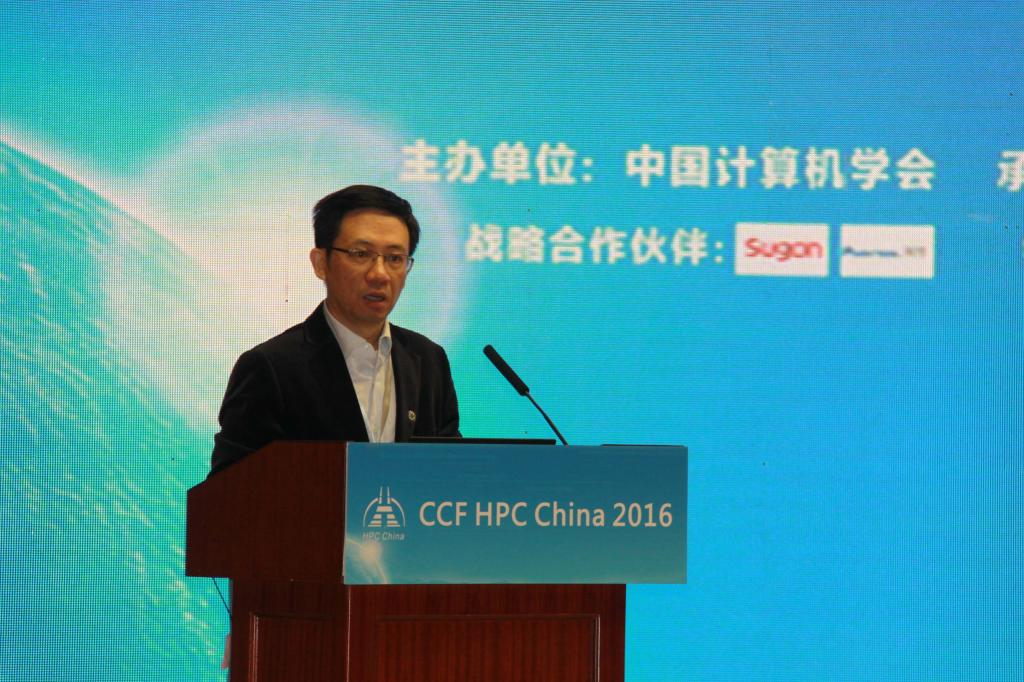

In [76]:
#cv2.imshow('out',image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
cv2_imshow(image)

###Checking a passport size image

In [77]:
image=cv2.imread('intern/trainset/0008/0008_0001461/0008_0001461_script.jpg')

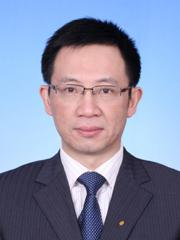

In [78]:
#cv2.imshow('out',image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
cv2_imshow(image)

##Inception Model

In [85]:
def inception_block_1a(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_3a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(128,(3,3),data_format='channels_first',name='inception_3a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(16,(1,1),data_format='channels_first',name='inception_3a_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(32,(5,5),data_format='channels_first',name='inception_3a_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)
    
    X_1=Conv2D(64,(1,1),data_format='channels_first',name='inception_3a_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_5,X_pool,X_1],axis=1)
    return inception

def inception_block_1b(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_3b_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(128,(3,3),data_format='channels_first',name='inception_3b_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(32,(1,1),data_format='channels_first',name='inception_3b_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(64,(5,5),data_format='channels_first',name='inception_3b_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_first')(X)
    X_P=Conv2D(64,(1,1),data_format='channels_first',name='inception_3b_pool_conv')(X_P)
    X_P=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(4,4),data_format='channels_first')(X_P)
    
    X_1=Conv2D(64,(1,1),data_format='channels_first',name='inception_3b_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3b_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_5,X_P,X_1],axis=1)
    return inception

def inception_block_1c(X):
    X_3=Conv2D(128,(1,1),data_format='channels_first',name='inception_3c_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3c_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(256,(3,3),strides=(2,2),data_format='channels_first',name='inception_3c_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3c_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(32,(1,1),data_format='channels_first',name='inception_3c_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3c_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(64,(5,5),strides=(2,2),data_format='channels_first',name='inception_3c_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_3c_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=MaxPooling2D(pool_size=3,strides=2,data_format='channels_first')(X)
    X_P=ZeroPadding2D(padding=((0,1),(0,1)),data_format='channels_first')(X_P)
    

    inception=concatenate([X_3,X_5,X_P],axis=1)
    return inception

def inception_block_2a(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_4a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(192,(3,3),data_format='channels_first',name='inception_4a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(32,(1,1),data_format='channels_first',name='inception_4a_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(64,(5,5),data_format='channels_first',name='inception_4a_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_first')(X)
    X_P=Conv2D(128,(1,1),data_format='channels_first',name='inception_4a_pool_conv')(X_P)
    X_P=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_first',name='inception_4a_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_5,X_P,X_1],axis=1)
    return inception

def inception_block_2b(X):
    X_3=Conv2D(160,(1,1),data_format='channels_first',name='inception_4e_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4e_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(256,(3,3),strides=(2,2),data_format='channels_first',name='inception_4e_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4e_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(64,(1,1),data_format='channels_first',name='inception_4e_5x5_conv1')(X)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4e_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=Conv2D(128,(5,5),strides=(2,2),data_format='channels_first',name='inception_4e_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=1,epsilon=0.00001,name='inception_4e_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=MaxPooling2D(pool_size=3,strides=2,data_format='channels_first')(X)
    X_P=ZeroPadding2D(padding=((0,1),(0,1)),data_format='channels_first')(X_P)

    inception=concatenate([X_3,X_5,X_P],axis=1)
    return inception

def inception_block_3a(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_5a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(384,(3,3),data_format='channels_first',name='inception_5a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)

    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_first')(X)
    X_P=Conv2D(96,(1,1),data_format='channels_first',name='inception_5a_pool_conv')(X_P)
    X_P=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5a_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_first',name='inception_5a_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_P,X_1],axis=1)
    return inception
def inception_block_3b(X):
    X_3=Conv2D(96,(1,1),data_format='channels_first',name='inception_5b_3x3_conv1')(X)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5b_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=Conv2D(384,(3,3),data_format='channels_first',name='inception_5b_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5b_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    
    X_P=MaxPooling2D(pool_size=(3,3),strides=2,data_format='channels_first')(X)
    X_P=Conv2D(96,(1,1),data_format='channels_first',name='inception_5b_pool_conv')(X_P)
    X_P=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5b_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_first',name='inception_5b_1x1_conv')(X)
    X_1=BatchNormalization(axis=1,epsilon=0.00001,name='inception_5b_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_P,X_1],axis=1)
    return inception


def FinalModel(input_shape):
    
    X_input=Input(input_shape)
    
    X=ZeroPadding2D(padding=(3,3))(X_input)
    X=Conv2D(64,(7,7),strides=(2,2),name='conv1')(X)
    X=BatchNormalization(axis=1,name='bn1')(X)
    X=Activation('relu')(X)
    
    X=ZeroPadding2D((1,1))(X)
    X=MaxPooling2D((3,3),strides=2)(X)
    
    X=Conv2D(64,(1,1),strides=(1,1),name='conv2')(X)
    X=BatchNormalization(axis=1,epsilon=0.00001,name='bn2')(X)
    X=Activation('relu')(X) 
    
    X=ZeroPadding2D(padding=(1,1))(X)
    
    X=Conv2D(192,(3,3),strides=(1,1),name='conv3')(X)
    X=BatchNormalization(axis=1,epsilon=0.00001,name='bn3')(X)
    X=Activation('relu')(X)
    
    X=ZeroPadding2D(padding=(1,1))(X)
    X=MaxPooling2D(pool_size=(3,3),strides=(2,2))(X)
    
    X=inception_block_1a(X)
    X=inception_block_1b(X)
    X=inception_block_1c(X)
    
    X=inception_block_2a(X)
    X=inception_block_2b(X)
    
    X=inception_block_3a(X)
    X=inception_block_3b(X)
    
    X=AveragePooling2D(pool_size=(3,3),strides=(1,1),data_format='channels_first')(X)
    X=Flatten()(X)
    X=Dense(128,activation='relu',kernel_initializer='glorot_normal',name='dense_layer')(X)
    X=Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_1')(X)
    
    model=Model(inputs=X_input,outputs=X,name='FaceRecognotionModel')
    return model    


In [86]:
model=FinalModel(input_shape=(3,96,96))

Checking the model

In [ ]:
i=np.random.rand(1,3,96,96)

In [ ]:
pred=model.predict(i)

In [ ]:
pred.shape

(1, 128)

Inception model working correctly as returning output of shape (1,128) 

In [87]:
model.summary()

Model: "FaceRecognotionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
_______________________________________________________________________________

Potting the model

In [ ]:
from keras.utils import plot_model

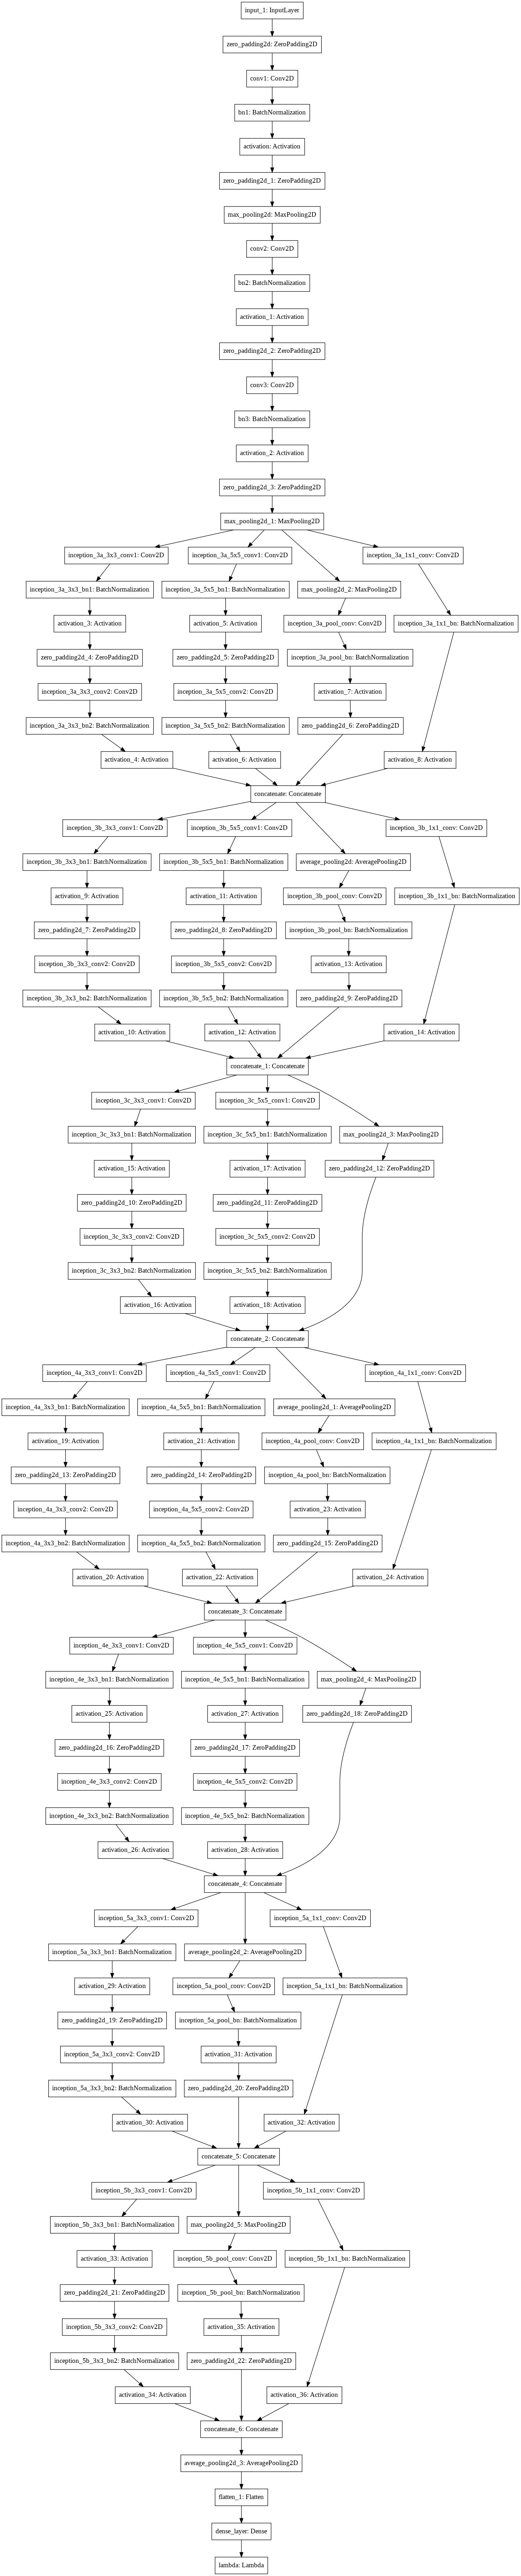

In [ ]:
plot_model(model,to_file='Inception_one_shot.png')

##Defining Loss Function and checking is it is working


In [82]:
#defining the triplet loss
def triplet_loss_t(y_true,y_pred):
    #print(y_pred)
    anchor=y_pred[:,0:128]
    pos=y_pred[:,128:256]
    neg=y_pred[:,256:384]
    
    positive_distance = K.sum(K.abs(anchor-pos), axis=1)
    negative_distance = K.sum(K.abs(anchor-neg), axis=1)
    probs=K.softmax([positive_distance,negative_distance],axis=0)
    #loss = positive_distance - negative_distance+alpha
    loss=K.mean(K.abs(probs[0])+K.abs(1.0-probs[1]))
    return loss

In [83]:
#Defining triple loss
def triplet_loss(y_true, y_pred, alpha = 0.2):
   
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    basic_loss =( pos_dist-neg_dist+alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))
  
    return loss

In [85]:
#Check loss for t
x=np.zeros((1,384))
y=np.random.random((4,384))
print(K.eval(triplet_loss_t(x,y)))

0.5610139857608085


##Image Preprocessing before feeded into the network

In [90]:
def localize_resize(path_image,path_haar='/haarcascade_frontalface_default.xml'):
    image=cv2.imread(path_image)
    #image=image.astype('float32')/255.0
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier=cv2.CascadeClassifier(path_haar)
    faces=classifier.detectMultiScale(gray,1.1,6)
    if len(faces) != 1:#condition if we dont have any faces or cant be detected y haar cascade we will skip those
        return -1
    #print(type(faces))
    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]
    image=cv2.resize(crop,(96,96))
    image=np.transpose(image,(2,0,1))
    image=image.astype('float32')/255.0
    return image

##Defining Generator

In [91]:

##Creating a Data Set in order to use triplet loss 


def data_gen(batch_size=32):
    while True:
        i=0
        positive=[]
        anchor=[]
        negative=[]    
        

        while(i<batch_size):
            r=random.choice(os.listdir(PATH))
            p=PATH+'/'+ r
            id=os.listdir(p)
            ra=random.sample(id,2)
            pos_dir=p+'/'+ra[0]
            neg_dir=p+'/'+ra[1]
            pos=pos_dir+'/'+random.choice(os.listdir(pos_dir))
            anc=pos_dir+'/'+random.choice([x for x in os.listdir(pos_dir) if 'script' in x])
            neg=neg_dir+'/'+random.choice(os.listdir(neg_dir))
            pos_img=localize_resize(pos,path_haar)
                    #print(pos+anc+neg)
            if pos_img is -1:
                continue
            neg_img=localize_resize(neg,path_haar)
            if neg_img is -1:
                continue
            anc_img=localize_resize(anc,path_haar)
            if anc_img is -1:
                continue
            positive.append(list(pos_img))
                #print('positive{0}'.format(i))
            negative.append(list(neg_img))
                #print('negative{0}'.format(i))
            anchor.append(list(anc_img))
                #print('anchor{0}'.format(i))
            i=i+1
        #return anchor,positive,negative
        yield ([np.array(anchor),np.array(positive),np.array(negative)],np.zeros((batch_size,1)).astype("float32"))
    

Check for generator

In [92]:
data_gen(3)

<generator object data_gen at 0x7ff61c51bf10>

##Triplet Model architecture

In [94]:
triplet_model_a=Input((3,96,96))
triplet_model_n=Input((3,96,96))
triplet_model_p=Input((3,96,96))
triplet_model_out=Concatenate()([model(triplet_model_a),model(triplet_model_p),model(triplet_model_n)])
triplet_model=Model([triplet_model_a,triplet_model_p,triplet_model_n],triplet_model_out)

In [95]:
triplet_model.compile(optimizer='adam',loss=triplet_loss_t,metrics=['accuracy'])

In [96]:
triplet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
FaceRecoModel (Functional)      (None, 128)          3743280     input_1[0][0]                    
                                                                 input_3[0][0]         

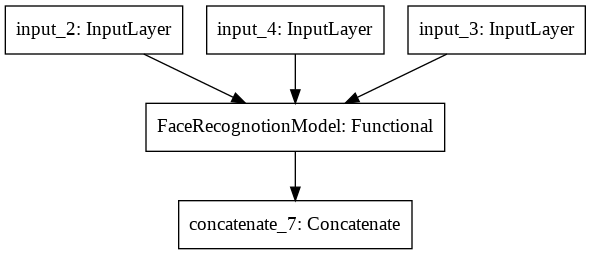

In [ ]:
plot_model(triplet_model)

In [ ]:
triplet_model.fit_generator(data_gen(),steps_per_epoch=232,epochs=12)

Epoch 1/12
232/232 [==============================] - 1s 3ms/step - loss: 0.4545 - accuracy: 0.8764
Epoch 2/12
232/232 [==============================] - 1s 3ms/step - loss: 0.2097 - accuracy: 0.9415
Epoch 3/12
232/232 [==============================] - 1s 2ms/step - loss: 0.1556 - accuracy: 0.9557
Epoch 4/12
232/232 [==============================] - 1s 2ms/step - loss: 0.1238 - accuracy: 0.9643
Epoch 5/12
232/232 [==============================] - 1s 2ms/step - loss: 0.1012 - accuracy: 0.9712
Epoch 6/12
232/232 [==============================] - 1s 2ms/step - loss: 0.0846 - accuracy: 0.9763
Epoch 7/12
232/232 [==============================] - 1s 3ms/step - loss: 0.0731 - accuracy: 0.9793
Epoch 8/12
232/232 [==============================] - 1s 3ms/step - loss: 0.0633 - accuracy: 0.9817
Epoch 9/12
232/232 [==============================] - 1s 3ms/step - loss: 0.0554 - accuracy: 0.9840
Epoch 10/12
232/232 [==============================] - 1s 3ms/step - loss: 0.0483 - accuracy: 0.9864

In [ ]:
triplet_model.save('One_Shot.h5')

##Loading Model

In [18]:
model=keras.models.load_model('One_Shot.h5')

##Implementing Model

In [51]:
def image_resizing(image,path_haar='/haarcascade_frontalface_default.xml'):
    #image=cv2.imread(path_image)
    #image=image.astype('float32')/255.0
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier=cv2.CascadeClassifier(path_haar)
    faces=classifier.detectMultiScale(gray,1.1,6)
    #print(type(faces))
    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]
    image=cv2.resize(crop,(96,96))
    #image=np.transpose(image,(2,0,1))
    #image=image.astype('float32')/255.0
    return image

In [50]:
#function to encode the given image
def encode_img(img1,model):
    #img1=cv2.imread(path,1)
    img=img1[...,::-1]
    img=np.around(np.transpose(img,(2,0,1))/255,decimals=12)
    x_train=np.array([img])
    emb=model.predict_on_batch(x_train)
    return emb


In [30]:
image_test=cv2.imread('intern/trainset/0008/0008_0001461/0000005.jpg')

In [58]:
image=image_resizing(image_test,path_haar)

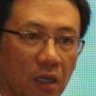

In [59]:
cv2_imshow(image)

In [64]:
enc1=encode(image,model)

In [65]:
enc1.shape

(1, 128)

In [66]:
ref=cv2.imread('intern/trainset/0008/0008_0001461/0008_0001461_script.jpg')

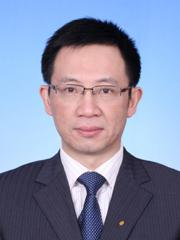

In [67]:
cv2_imshow(ref)

In [68]:
image=image_resizing(ref,path_haar)

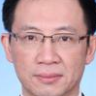

In [74]:
cv2_imshow(image)

In [69]:
ref_enc=encode_img(image,model)

### measuring the norm between the two encodings with 0.5 as threshold

In [97]:
dist=np.linalg.norm((ref_enc-enc1))
confidence=(0.5-dist)/0.5
if dist < 0.5:
    print("Match Found with confidence ",confidence*100)
else:
    print("No Match")

Match Found with confidence  81.35951906442642
